# Exploration of Sequential Monte Carlo / Weighted Particle Methods
Following [https://www.stats.ox.ac.uk/~doucet/doucet_johansen_tutorialPF2011.pdf](https://www.stats.ox.ac.uk/~doucet/doucet_johansen_tutorialPF2011.pdf).
Doucet pioneered SMC methods, and he is currently a senior research scientist at Google DeepMind.

I'm not great at determining how much information is best for presentation. Feel free to skip whatever is not interesting to you. I've already pruned alot from the original tutorial, but this notebook is pretty long. The code portions are densest at the end of this notebook.
## Table of Contents 




# Stochastic volatility model described in Doucet's SMC tutorial
*So I couldn't figure out how to enable spellcheck on my local Jupyter Notebook server. If there are typos, please let me know by email: johnma@udel.edu*


Consider the stochastic processes, $\{X_n\}_{n \ge 0}$ modeling hidden Markov states of volatility for a specified financial instrument,
$$
X_n = \alpha X_{n-1} + \sigma V_n,
$$
and $\{Y_n\}_{n\ge 0}$,
$$
Y_n = \beta \exp(X_n / 2) W_n
$$
modeling observations of instrument price,
where $\sigma, \alpha, \beta$ are all real valued parameters,
$V_n \sim \mathcal{N}(0,1), W_n \sim \mathcal{N}(0,1)$, all iid.
Doucet describes the first hidden Markov state 
as $X_1 \sim \mathcal{N}\left(0, \frac{\sigma^2}{1-\alpha^2}\right).$ I think we can change the mean to tweak this, 
say for instance to model a live instrument started yesterday.

(This is a basic AR(1) process. I've found this resource detailing more rigorous models: [https://personal.ntu.edu.sg/nprivault/MA5182/stochastic-volatility.pdf](https://personal.ntu.edu.sg/nprivault/MA5182/stochastic-volatility.pdf). This notebook is focused on
exploring Sequential Monte Carlo, not as much on the economic modeling aspect itself.

But for now, how I understand this AR(1) is thus:
This is a simplified, countably indexed stochastic process modeling volatility.
The parameter alpha tunes how strongly the market remembers the previous state. Weaker values of alpha mean noisier markets, as the additive sigma noise takes over. Beta is a parameter tuning how reactive the market is to volatility.
)
# Let's run the stochastic process forward


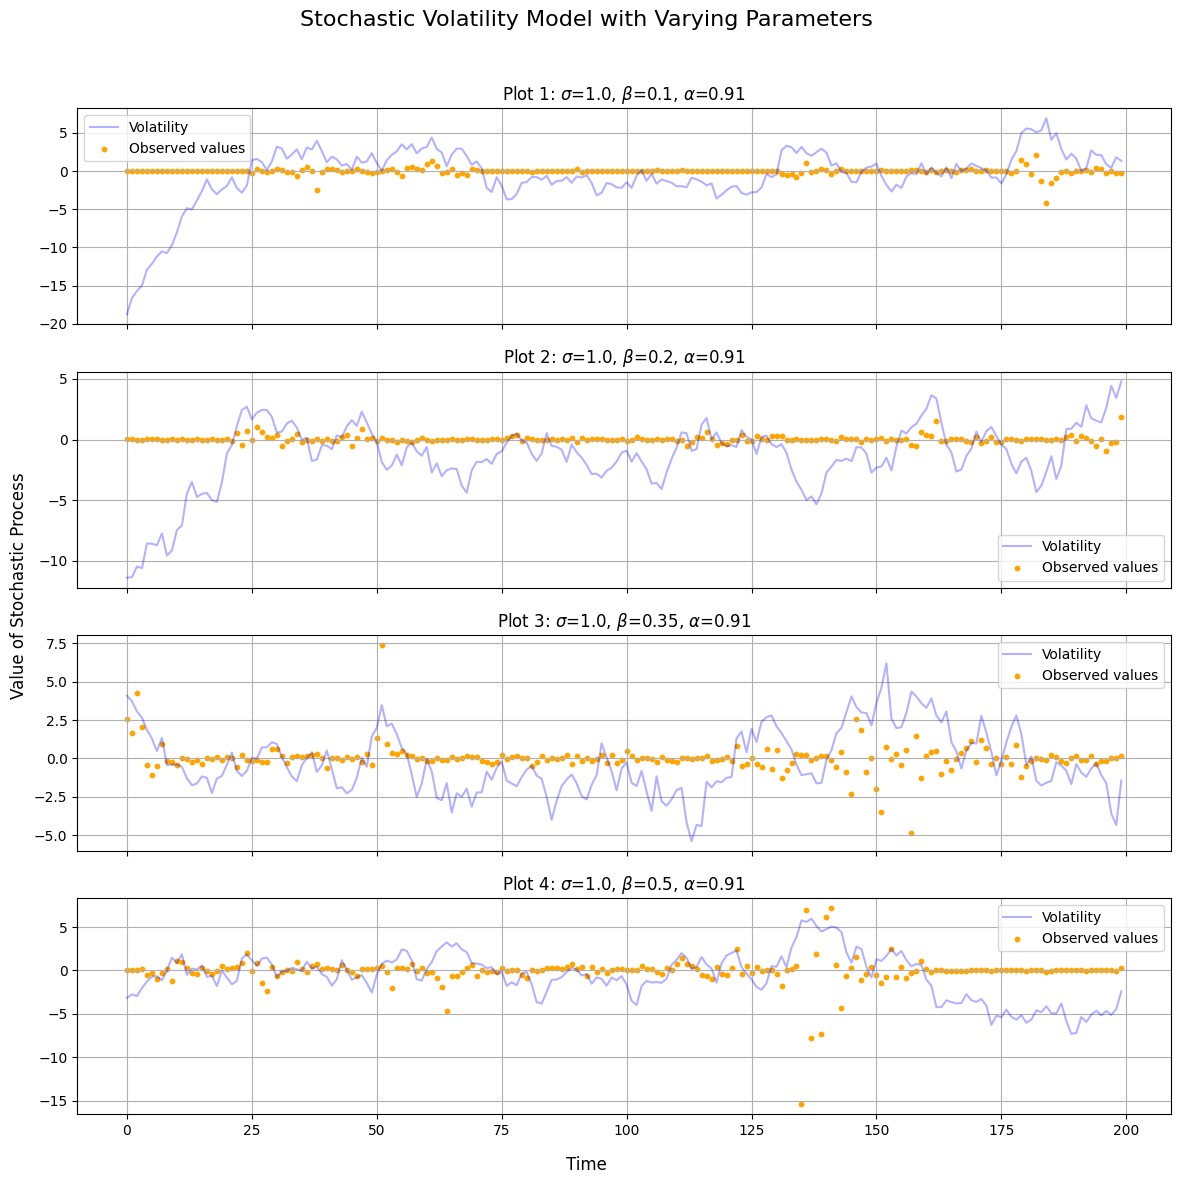

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Number of time steps
# We will use capital N for something else later
n = 200

# For multiple plots, keeping alpha and sigma fixed for now
sigma_param = [1.0, 1.0, 1.0, 1.0]
beta_param = [0.1, 0.2, 0.35, 0.5] 
alpha_param = [0.91, 0.91, 0.91, 0.91]

fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

for i in range(4):
    X = [0] * n
    Y = [0] * n

    sigma = sigma_param[i]
    beta = beta_param[i]
    alpha = alpha_param[i]

    X[0] = np.random.normal(0, sigma / (1 - alpha))
    Y[0] = beta * np.exp(X[0] / 2) * np.random.normal(0, 1)

    for t in range(1, n):
        X[t] = alpha * X[t - 1] + sigma * np.random.normal(0, 1)
        Y[t] = beta * np.exp(X[t] / 2) * np.random.normal(0, 1)

    axes[i].plot(X, label='Volatility', color='blue', alpha=0.3)
    axes[i].scatter(range(n), Y, label='Observed values', color='orange', s=10, alpha=1.0)
    axes[i].set_title(rf'Plot {i+1}: $\sigma$={sigma}, $\beta$={beta}, $\alpha$={alpha}')
    axes[i].legend()
    axes[i].grid(True)

# Shared labels
fig.suptitle('Stochastic Volatility Model with Varying Parameters', fontsize=16)
fig.supxlabel('Time')
fig.supylabel('Value of Stochastic Process')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Importantly... in this simple model, 
we have that $\{X_n\}_{n\ge 0}$ evolves according to the
transition density $f(x' \mid x)= \mathcal{N}(x'; \alpha x, \sigma^2)$, and
$\{Y_n\}_{n\ge 0}$ evolves according to the transition density $g(y\mid x) = \mathcal{N}(y; 0, \beta^2 \exp(x))$. We note that the given mean zero initial distribution ensures
the marginal distribution of each $X_n$ is also $\mathcal{N}\left(x;0,\frac{\sigma^2}{1-\alpha^2}\right)$, for all $n$.

# Filtering theory basics, skip if not interesting
*Skip to
[Sequential Monte Carlo methods](#Sequential-Monte-Carlo-methods)
if you'd like to skip the basics.*

*Skip to
[SIS modeling of our stochastic volatility model](#SIS-modeling-of-our-stochastic-volatility-model)
if you just want to view the code.*


Suppose we have  realizations of the observations $Y_{1:n} = y_{1:n}$.
We are interested in the sequential approximation of the distributions
$\{p(x_{1:n} \mid y_{1:n})\}_{n\ge 1}$ (and the marginal likelihoods $\{p(y_{1:n})\}_{n\ge 1}$). 
Generally we assume a prior distribution for $\{X_n\}_{n\ge 1}$ which can be factored 
\begin{equation}
p(x_{1:n}) = \mu(x_1) \prod_{k=2}^2 f(x_k \mid x_{k-1}), \tag{1}
\end{equation}
for initial distribution $\mu(x)$ and transition density $f(x_k \mid x_{k-1}),$ 
as well as a likelihood function factorizable as
\begin{equation}
p(y_{1:n} \mid x_{1:n}) = \prod_{k=1}^n g(y_k \mid x_k),\tag{2}
\end{equation}
for marginal density $g(y \mid x).$

By Bayes',
\begin{equation}
p(x_{1:n} \mid y_{1:n}) = \frac{p(x_{1:n}, y_{1:n})}{p(y_{1:n})},\tag{3}
\end{equation}
where 

\begin{equation}
p(x_{1:n}, y_{1:n}) = p(x_{1:n})p(y_{1:n}\mid x_{1:n}),\tag{4}
\end{equation} and 
\begin{equation}
p(y_{1:n}) = \int p(x_{1:n}, y_{1:n})\,dx_{1:n}.\tag{5}
\end{equation}

### We claim that ...
the general unnormalized posterior distribution $p(x_{1:n}, y_{1:n})$ described above satisfies the recursion
\begin{equation}
p(x_{1:n}, y_{1:n}) = p(x_{1:n-1}, y_{1:n-1}) f(x_n \mid x_{n-1}) g(y_n \mid x_n).\tag{6}
\end{equation}
To see this, directly apply (1) and (2) to (4).
 We can do something similar for the normalized posterior:
\begin{equation}
p(x_{1:n} \mid y_{1 : n}) = p(x_{1: n-1}\mid y_{1:n-1}) \frac{f(x_n \mid x_{n-1})g(y_n\mid x_n)}{p(y_n \mid y_{1 : n-1})}\tag{7},
\end{equation}
where we've written
\begin{equation}
p(y_n \mid y_{1:n-1}) = \int p(x_{n-1} \mid y_{1 : n-1}) f(x_n \mid x_{n-1})g(y_n \mid x_n) \,dx_{n-1 : n}.
\tag{8}
\end{equation}

### We can also derive the recursion satisfied by the marginal $p(x_n \mid y_{1:n})$.
Consider integrating out $x_{1:n-1}$ in (7):
\begin{align*}
p(x_{n}\mid y_{1:n}) =
\int p(x_{1:n} \mid y_{1:n})\,dx_{1:n-1} &= \int p(x_{1: n-1}\mid y_{1:n-1}) \frac{f(x_n \mid x_{n-1})g(y_n\mid x_n)}{p(y_n \mid y_{1 : n-1})} \,dx_{1:n-1}\tag{9}\\
&:= \frac{p(x_{n-1}\mid y_{1:n-1}) g(y_n \mid x_n)}{p(y_n \mid y_{1 : n-1})},\tag{10}
\end{align*}
where we set
\begin{equation}
p(x_n \mid y_{1:n-1}) := \int p(x_{n-1}\mid y_{1:n-1}) f(x_n \mid x_{n-1})\,dx_{n-1}.\tag{11}
\end{equation}
We call (11) the prediction step, and we call (9)-(10) the updating step. But in practice, most particle
filtering methods rely on 
numerically approximating (7), and not (9)-(11).

If we can compute $\{p(x_{1:n} \mid y_{1:n})\}$ and 
thus $\{p(x_n \mid y_{1:n})\}$ sequentially, then the quantity $p(y_{1:n})$ which is
known as the marginal likelihood can be evaluated recursively using
\begin{equation}
p(y_{1:n}) = p(y_1)\prod_{k=2}^n p(y_k \mid y_{1:k-1}),\tag{12}
\end{equation}
where $p(y_k \mid y_{1:k-1})$ is of the form (8).

# Smoothing
Whereas filtering estimates the distribution of the current state of a HMM based on observations
received up until the current time, smoothing corresponds
to estimating the distribution of the state at a particular time given all of the observations
up to some later time.

The trajectory estimates obtained by smoothing tend to be better than those obtained by filtering, as a result of additional information available.
Formally, assume we have access to data $y_{1:T}$ and wish to compute the marginal distributions
$\{p(x_n \mid y_{1:T})\}$ where $n = 1,\ldots, T$, or to sample from $p(x_{1:T} \mid y_{1:T})$. 

A naive way to accomplish this would be to consider the joint distribution $p(x_{1:T} \mid y_{1:T})$ and to integrate out the variables you didn't want to consider. In the context of particle methods, this would
mean using the identity $$p(x_n \mid y_{1:T}) = \int p(x_{1:T} \mid y_{1:T}) \,dx_{1:n-1} \,dx_{n+1: T},$$
and taking the Monte Carlo approach and obtaining an approximate characterization of the joint distiribution, and using the associated marginal distribution to approximate the distributions of interest.

Unfortunately, as we will see, when $n \ll T$, this strategy is doomed to fail, *since the marginal distribution
$p(x_n \mid y_{1:n})$ occupies a privileged role within the particle filter framework, as it is better characterized than any of the other marginal distributions.* 

### Alternative recursive decompositions 
Eventually we will want to proceed regardless into applying SMC methods to solve this smoothing problem.
We will need two recursions that will be useful when we need to apply numerical methods for certain downstream tasks.
#### Forward-Backward recursion
We can write 
the joint distribution $p(x_{1:T} \mid y_{1:T})$ as 
\begin{align}
p(x_{1:T} \mid y_{1:T}) &= p(x_T \mid y_{1:T}) \prod_{n=1}^{T-1} p(x_n \mid x_{n+1}, y_{1:T})\\
&= p(x_T \mid y_{1:T}) \prod_{n=1}^{T-1} p(x_n \mid x_{n+1}, y_{1:n}).\tag{13}
\end{align}
This tells us that conditioned on $y_{1:T}$, $\{X_n\}$ is an inhomogeneous Markov process.
Eq. (13) gives rise to the following algorithm to sample from $p(x_{1:T} \mid y_{1:T})$. 

- First, compute and store the marginal distributions $\{p(x_n \mid y_{1:n})\}_{n=1}^T$.
- Sample $X_T \sim p(x_T \mid y_{1:T})$.
- For $n = T-1, T-2, \ldots, 1,$ sample $X_n \sim p(x_n \mid x_{n+1}, y_{1:n}),$ where $$
  p(x_n \mid x_{n+1}, y_{1:n}) = \frac{f(x_{n+1} \mid x_n) p(x_n \mid y_{1:n})}{p(x_{n+1}\mid y_{1:n})}.$$
- It follows that by integrating out $(x_{1:n-1}, x_{n+1: T})$ in (13), that
  \begin{equation}
  p(x_{n}\mid y_{1:T}) = p(x_n \mid y_{1:n}) \int \frac{f(x_{n+1} \mid x_n)}{p(x_{n+1} \mid y_{1:n})}p(x_{n+1} \mid y_{1:T})\,dx_{n+1}.\tag{14}
  \end{equation}
  So to compute $\{p(x_n \mid y_{1:T})\},$ we simply modify the backward pass, and instead of sampling from
  $p(x_n\mid x_{n+1}, y_{1:n})$, we compute $p(x_n \mid y_{1:T})$ using (14).


#### Generalized two-filter formula
A well-established alternative to the forward-filtering backward-smoothing technique to compute
the marginal distributions $\{p(x_n \mid y_{1:T})\}$ is the two-filter formula, due to Bresler in 1986.
It relies on the identity
\begin{equation}
p(x_n \mid y_{1:T}) = \frac{p(x_n \mid y_{1: n-1}) p(y_{n : T} \mid x_n)}{p(y_{n:T} \mid y_{1: n-1})},
\end{equation}
where the so-called backward information filter is initialized at time $n = T$ by $p(y_T \mid x_T) = g(y_T\mid x_T)$ and satisfies
\begin{align}
p(y_{n:T} \mid x_n) &= \int \prod_{k= n+1}^T f(x_k \mid x_{k-1}) \prod_{k= n}^T g(y_k \mid x_k)\,dx_{n+1:T}\tag{15}\\
&= g(y_n\mid x_n) \int f(x_{n+1} \mid x_n) p(y_{n+1: T}\mid x_{n+1})\,dx_{n+1}
\end{align}
It's claimed that the backward information filter is not a probability density in argument $x_n$, and its possible that $\int p(y_{n : T} \mid x_n) \,dx_n = \infty$. This is not an issue if
$p(y_{n:T} \mid x_n)$ can be computed exactly, but it does preclude the direct use of SMC methods to 
estimate this integral. 

To address this problem, Doucet, the author of this tutorial proposed in 2008, the following
generalized two-filter formula. We introduce a set of artificial probability
distributions $\{\tilde{p}_n(x_n)\}$ with joint distribution
\begin{equation}
\tilde{p}(x_{n:T} \mid y_{n:T}) \propto \tilde{p}_n(x_n)\prod_{k= n+1}^T f(x_k \mid x_{k-1}) \prod_{k=n}^T g(y_k \mid x_k),
\end{equation}
which are constructed so that their marginal distributions $\tilde{p}_n (x_n \mid y_{n : T}) \propto \tilde{p}_n(x_n) p(y_{n:T} \mid x_n)$ are "integrable versions" of the backward information filter.

We can establish the generalized two-filter formula 
\begin{equation}
p(x_1 \mid y_{1:T}) \propto \frac{\mu(x_1) \tilde{p}(x_1\mid y_{1:T})}{\tilde{p}_1(x_1)}, \quad p(x_n \mid y_{1:T}) \propto \frac{p(x_n \mid y_{1: n -1})\tilde{p}(x_n\mid y_{n:T})}{\tilde{p}_n(x_n)},
\end{equation}
which we claim is valid when the support of $\tilde{p}_n(x_n)$ includes the support of the prior $p_n(x_n)$, that is,
$$
p_n(x_n) = \int\mu(x_1) \prod_{k=2}^n f(x_k \mid x_{k-1}) \,dx_{1:n-1} > 0 \Longrightarrow \tilde{p}_n(x_n) > 0.
$$
We will use this generalized two-filter formula later.


## Sequential Monte Carlo methods
It is traditional in SMC literature to present particle filtering and SMC as the same thing, 
but really SMC encompoasses a broader range of algorithms. Doucette would like to build 
a general framework to demonstrate exactly this. 
We describe SMC methods as a general class of Monte Carlo methods that sample sequentially from
a sequence of target probability densities $\{\pi_n(x_{1:n})\}$ of increasing dimension.
Specifically, if $\mathcal{X}$ is our state space, then each distribution $\pi_n(x_{1:n})$ is
defined on the product space $\mathcal{X}^n$.

Suppose that $\pi_n(x_{1:n})$ is known pointwise up to a normalizing constant:
\begin{equation}
\pi_n(x_{1:n}) = \frac{\gamma_n(x_{1:n})}{Z_n},\tag{16}
\end{equation}
$\gamma_n : \mathcal{X}^n \to \mathbb{R}^+$ is known pointwise, and 
\begin{equation}
Z_n = \int \gamma_n(x_{1:n})\,dx_{1:n}\tag{17}
\end{equation}
is generally unknown. SMC methods provide an approximation of $\pi_1(x_1)$ and an estimate of 
$Z_1$ at time 1, then an approximation of $\pi_2(x_{1:2})$ and an estimate of $Z_2$ at time 2, and so on.
In the filtering context, $\gamma_n(x_{1:n}) = p(x_{1:n}, y_{1:n}), Z_n = p(y_{1:n}),$ and $\pi_n(x_{1:n}) = p(x_{1:n}\mid y_{1:n})$.

### Monte Carlo methods in the ideal case
Consider now approximating a generic probability density $\pi_n(x_{1:n})$, for a fixed $n$. If we sample
$N$ independent random variables $X_{1:n}^i \sim \pi_n(x_{1:n})$, for $i = 1,\ldots, N$, then we
can approximate $\pi_n(x_{1:n})$ by the empirial measure
$$
\hat{\pi}_n (x_{1:n}) = \frac{1}{N} \sum_{i=1}^N \delta_{X_{1:n}^i}(x_{1:n}),
$$
where $\delta_{x_0}(x)$ is the Dirac delta mass centered at $x_0$.
We can approximate any marginal $\pi_n(x_k)$ using 
$$
\hat{\pi}_n(x_k) = \frac{1}{N} \sum_{i=1}^N \delta_{X_k^i}(x_k),
$$
and the expectation of any test function $\varphi_n : \mathcal{X}^n \to \mathbb{R}$,
$$I_n(\varphi_n) := \int \varphi_n(x_{1:n})\pi_n(x_{1:n})\,dx_{1:n}$$
using 
$$
I_n^{\text{MC}}(\varphi_n) := \int \varphi_n(x_{1:n})\hat{\pi}_n(x_{1:n})\,dx_{1:n} = \frac{1}{N} \sum_{i=1}^N \varphi_n(X_{1:n}^i).
$$
This estimate is unbiased, with variance
$$
\operatorname{Var}(I^{\text{MC}}_n(\varphi_n)) = \frac{1}{N} \left(
\int \varphi_n^2(x_{1:n}) \pi_n(x_{1:n}) \,dx_{1:n} - I_n^2(\varphi_n)
\right)
$$
The approximation error of our Monte Carlo estimate decreases at a rate of $\mathcal{O}(1/N)$, independent of
the space $\mathcal{X}^n$. 
Of course, in general we will probably never be able to sample from $\pi_n(x_{1:n})$ (but this is changing rapidly for certain problems, see generative diffusion models), and if we were able to draw samples, any sampling 
scheme would typically be linear in the number of variables (also not generally true for generative diffusion models).

### Importance Sampling
To solve the problem of generally being unable to sample from high-dimensional probability distributions, we introduce importance sampling. 
Let $q_n(x_{1:n})$ be a probability density, which we will call the importance density,
whose support contains the support of $\pi_n(x_{1:n})$, for all $n \in \mathbb{Z}^+$, with
$\pi_n(x_{1:n})$ is defined in (16)-(17).
Then the following identities are given:
\begin{equation}
\pi_n(x_{1:n}) = \frac{w_n(x_{1:n}) q_n(x_{1:n})}{Z_n},
\end{equation}
where 
\begin{equation}
Z_n = \int w_n(x_{1:n})q_n(x_{1:n})\,dx_{1:n},
\end{equation}
and
$w_n(x_{1:n})$, called the unnormalized weight function, is defined
by
\begin{equation}
w_n(x_{1:n}) = \frac{\gamma_n(x_{1:n})}{q_n(x_{1:n})}.
\end{equation}

We typically choose an importance density $q_n(x_{1:n})$ which is easy to draw samples from, such as a multivariate Gaussian. 
Assume we draw $N$ independent samples $X_{1:n}^i \sim q_n(x_{1:n})$. Then we can consider the following weighted Monte Carlo approximations
\begin{equation}
\hat{\pi}_n(x_{1:n}) = \sum_{i=1}^N W_n^i \delta_{X_{1:n}^i}(X_{1:n}),\tag{IS1}
\end{equation}
and 
\begin{equation}
\hat{Z}_n = \frac{1}{N} \sum_{i=1}^N w_n(X_{1:n}^i),\tag{IS2}
\end{equation}
where 
\begin{equation}
W_n^i = \frac{w_n(X_{1:n}^i)}{\sum_{j=1}^N w_n(X_{1:n}^j)}.
\end{equation}

Importance sampling provides an unbiased estimate of the normalizing constant with
known relative variance:
\begin{equation}
\frac{
\operatorname{Var}_{\text{IS}}
(\hat{Z}_n)
}
{Z_n^2} = \frac{1}{N} \left(
\int
 \frac{\pi_n^2(x_{1:n})}
      {q_n(x_{1:n})}
\,dx_{1:n} - 1
\right).
\tag{18}
\end{equation}
We can also approximate expectations
$$
I_n^{\text{IS}}(\varphi_n) = \int \varphi_n(x_{1:n}) \hat{\pi}_n(x_{1:n}) \,dx_{1:n} = \sum_{i=1}^N W_n^i \varphi_n(X_{1:n}^i).$$
This estimate is biased for finite $N$, but it is consistent, and we claim that
\begin{equation}
\lim_{N\to\infty} N(I_{n}^{\text{IS}} - I_n(\varphi_n)) = -\int\frac{\pi_n^2(x_{1:n})}{q_n(x_{1:n})}(\varphi_n(x_{1:n}) - I_n(\varphi_n)) \,dx_{1:n}.
\end{equation}
We claim that when the normalizing constant is known analytically, we can calculate an unbiased importance
smapling estimate, but this generally has higher variance and is not useful in situations which we
are interested in.

Furthermore, $I_n^{\text{IS}}(\varphi)$ satisfies a Central Limit Theorem
$$
\sqrt{N}(I_n^{\text{IS}}(\varphi) - I_n(\varphi))\xrightarrow{d} \mathcal{N}(0,\sigma^2),
$$
with asymptotic variance
\begin{equation}
\sigma^2 = \int \frac{\pi_n^2(x_{1:n})}{q_n(x_{1:n})}(\varphi_n(x_{1:n})-I_n(\varphi_n))^2\,dx_{1:n}.\tag{19}
\end{equation}
The most correct approach to choosing an importance distribution is thus to try and minimize this asymptotic variance (19). For a given test function $\varphi_n(x_{1:n})$ it is not too hard to establish an importance distribution minimizing (19), but we'd like to choose an importance distribution independently of $\varphi_n(x_{1:n})$. 

The better approach is to select $q_n(x_{1:n})$ minimizing the variance of the importance weights, or equivalently, the variance of $\hat{Z}_n$. Observing (18), the best choice is clearly $q_n(x_{1:n}) = \pi_n(x_{1:n}).$ But this is not possible, since inaccessibility to $\pi_n(x_{1:n})$ is why we need IS in the first place.

This simple result indicates that we should select an IS distribution that is close as possible to the target, and this is the advisable course of action.
If we aren't going to do this, we should at least make sure we select $q_n(x_{1:n})$ such that
$w_n(x_{1:n}) < \infty$.

## Sequential Importance Sampling
Add the following constraint by assuming that $q_n(x_{1:n})$ can be written 
\begin{align}
q_n(x_{1:n}) &= q_{n-1}(x_{1:n-1})q_n(x_n\mid x_{1:n-1})\\\
&= q_1(x_1)\prod_{k=2}^n q_k(x_k \mid x_{1:k-1}).
\end{align}
This gives us the recipe for Sequential Importance Sampling. Now, to obtain particles 
$X_{1:n}^i \sim q_n(x_{1:n})$ at time $n$, we sample $X_1^i \sim q_1(x_1)$ at time 1,
then $X_k^i \sim q_k(x_k \mid X_{1:k-1}^i)$, at time $k$, for $k = 2,\ldots, n$.

The associated unnormalized weights can also be computed recursively using the decomposition
\begin{align}
w_n(x_{1:n}) &= \frac{\gamma_n(x_{1:n})}{q_n(x_{1:n})}\\
&= \frac{\gamma_{n-1}(x_{1:n-1})}{q_{n-1}(x_{1:n-1})}
\frac{\gamma_n(x_{1:n})}{\gamma_{n-1}(x_{1:n-1})q_n(x_n \mid x_{1:n-1})},
\end{align}
which we write in the form
\begin{align}
w_n(x_{1:n}) &= w_{n-1}(x_{1:n-1})\cdot\alpha_n(x_{1:n})\\
&= w_1(x_1) \prod_{k=2}^n \alpha_k(x_{1:k}),
\end{align}
where the incremental importance weight function $\alpha_n(x_{1:n})$ is given by
\begin{equation}
\alpha_n(x_{1:n}) = \frac{\gamma_n(x_{1:n})}{\gamma_{n-1}(x_{1:n-1})q_n(x_{n}\mid x_{1:n-1})}.
\end{equation}

### Sequence Importance Sampling algorithm
We can now discuss a general algorithm to carry out SIS.
- At time $n = 1$,
    - sample $X_1^i \sim q_1(x_1).$
    - Compute the weights $w_1(X_1^i)$ and $W_1^i \propto w_1(X_1^i)$.
- At time $n \ge 2$,
    - sample $X_n^i \sim q_n(x_n \mid X_{1:n-1}^i)$.
    - Compute the weights
  \begin{align}
w_n(X_{1:n}^i) &= w_{n-1}(X_{1:n-1}^i)\cdot\alpha(X_{1:n}^i)\\
W_n^i &\propto w_n(X_{1:n}^i).
\end{align}

At any time $n$, we obtain the estimates $\hat{\pi}_n(x_{1:n}), \hat{Z}_n$ via (IS1) and (IS2) respectively.

## SIS modeling of our stochastic volatility model
